# ODK2AGOL

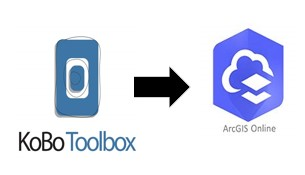

### BACKGROUND

ODK (Open Data Kit) is an open-source solution for offline mobile data collection based on XLS-coded forms. Once an ODK form is coded and uploaded to the ODK, ONA, or KOBO servers (All built on ODK technology), it can be used on mobile phones through applications such as Kobo Collect or ODK Collect for offline and/or online data collection (ODK - Collect Data Anywhere, n.d.). All the data collected is centralized in a database and can be accessed in various ways (APIs, spreadsheets etc) for further analysis.

While BI tools such as Power BI or Tableau can connect to ODK server through its available API to produce analysis and dashboards, these BI solutions do not offer spatial analysis capabilities offered by ArcGIS Online. Unfortunately, ArcGIS Online does not offer the possibility to connect to an external API directly from its user interface, and the walkaround until now was to do a manual process through downloading data, cleaning, and using ArcGIS to transform and publish to ArcGIS Online. But this is not a sustainable solution, especially for real-time streaming data.

### PROPOSED SOLUTION

Even though ArcGIS Online does not offer direct connections to APIs through its user interface, it offers a programming API that can be used to build scripts when needed. In this project, we want to leverage on the ArcGIS python API and Jupyter notebook to build a solution that will connect to ODK server, pull data, transform, and push to ArcGIS Online. 

The packages that will be used to build this script will be the request for HTTP request, Pandas for data manipulation and cleaning and transformation, arcgis API for connecting and pushing data to ArcGIS Online.

1. Importing libraries

In [ ]:
import requests as rq
import json
import os
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

2. HTTP request to the ODK server to retrieve data in the json format

For security reasons, we will not connect directly to the ODK API to retrieve data for this exercise. We will rather just use a downloaded version of the json data to be processed.

In [ ]:
#url : "https://[kpi-url]/assets/form_id/submissions/?format=json"
ES_data = rq.get("url", auth = ("user", "password"))
#ES_data.status_code # cheking for the status of the response
ES_data

3. Tranform the data to a pandas dataframe

In [ ]:
# This code is used when we connect to the ODK server through the API

data = ES_data.json() #change to json structure
df = pd.DataFrame(data) #change to pandas dataframe
df # display the data in form of a table

In [ ]:
df.info() #Check information on the table fields

In [ ]:
df["group_vr07r89/Coordonn_es_GPS_du_point"]

4. Split the geolocation column into Longitude and Latitude

In [ ]:
df[["Lon","Lat", "Alt", "Precision"]]=df["group_vr07r89/Coordonn_es_GPS_du_point"].str.split(" ", expand=True) #spliting the gps1 column containing the cordinates 

5. Convert the pandas dataframe into the Esri spatial enabled dataframe

In [ ]:
sedf = pd.DataFrame.spatial.from_xy(df,"Lat", "Lon") # converting from pandas dataframe to SADF
sedf = sedf.drop(["_tags","_notes","_attachments", "_geolocation", "_validation_status"], axis = 1)# drop out empty columns
sedf

In [ ]:
sedf.spatial.geometry_type #check the geometry type

In [ ]:
sedf.spatial.full_extent

6. Connect to ArcGIS online for data publication

    a. If you have direct access to your organization arcgis online without any restrictions, below can be used

In [ ]:
#https://org.maps.arcgis.com
#try:
#    arcpy.SignInToPortal(arcpy.GetActivePortalURL(), <user_name>, <password>)
#    print("Connected succesfully")
#except:
#    print("connection failed")

    b. In case "a" fails, try this

In [ ]:
import sys
os.environ["PATH"] = r"{};{}".format(os.environ["PATH"], r"C:\Program Files\ArcGIS\Pro\bin") # path has to be updated if you have installed Pro in a different location
sys.path.append(r"C:\Program Files\ArcGIS\Pro\Resources\ArcPy")                              # path has to be updated if you have installed Pro in a different location

import arcgis
from arcgis.gis import GIS

Create the GIS object to connect to ArcGIS Online content

In [ ]:
gis = GIS('Home')
gis

7. Check the existense of the feature layer and delete it

In [ ]:
# search for content in your gis with a query built from tilte, owner and item type
def searchAGOL(title, owner, itemType):
    return gis.content.search(query='title:'+title+' owner:'+owner, item_type=itemType)

# test whether items exist on AGOL for given title, owner, and item type and if so, delete them from AGOL
def deleteIfExistsOnAGOL(title, owner, itemType):
    result = searchAGOL(title, owner, itemType)   # search item
    print('Found items for title='+title+', owner='+owner+', itemType='+itemType+':')
    print(result)
    for item in result:                           # delete items found
        item.delete()
        print('Item ' + item.title + ' has been deleted.')

usernameAGOL = "Agol_UserName"
# delete existing acaule observation and prediction shapefiles and feature layers on AGOL
deleteIfExistsOnAGOL('douala', usernameAGOL, 'Geodatabase')
deleteIfExistsOnAGOL('douala', usernameAGOL, 'Feature Service')

8. convert the SEDF to a hostes featurelayer

In [ ]:
featureLayer = sedf.spatial.to_featurelayer(title='douala')
#featureLayer = sedf.spatial.to_featureclass(r"D:\PSU\Advance python programming\test4.shp", overwrite=True) #save in a local file
#featureLayer = gis.content.import_data(sedf) # Another online import option

In [ ]:
featureLayer

9. Visualization of the final result

In [ ]:
mapView = gis.map("Douala")
mapView.basemap = "streets"
mapView.add_layer(featureLayer)
mapView

# Conclusion

This notebook gives the possibility to the user to connect to a REST API, pull data in json format, convert the data into pandas dataframe, do some data vaidation, transforms the pandas dataframe into the ESRI spatially enabled dataframe and the publishes the data as a feature layer that can then be used for mapping and visualizations.